# Build a DNN using the Keras Functional API

Learning Objectives:
1. Review how to read CSV file data using tf.data
2. Specify input, hidden and output layers in the DNN architecture
3. Review and visualise the final DNN shape
4. Train the model locally and visualize the loss curves
5. Deploy and predict with the model using Cloud AI platform

In [1]:
import os, json, math
import numpy as np
import tensorflow as tf
import shutil
print("TensorFlow varsion:", tf.version.VERSION)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

TensorFlow varsion: 2.12.0


In [2]:
CSV_COLUMNS = [
    'fare_amount',
    'pickup_datetime',
    'pickup_longitude',
    'pickup_latitude',
    'dropoff_longitude',
    'dropoff_latitude',
    'passenger_count',
    'trips_last_5min',
    'key'
]

LABEL_COLUMN = 'fare_amount'

DEFAULTS = [[0.0], ['na'], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], ['na']]

In [3]:
def features_and_labels(row_data):
    for unwanted_col in ['pickup_datetime', 'key', 'trips_last_5min']:
        row_data.pop(unwanted_col)
    label = row_data.pop(LABEL_COLUMN)
    return row_data, label 

def load_dataset(pattern, batch_size=1, mode=tf.estimator.ModeKeys.EVAL):
  dataset = (tf.data.experimental.make_csv_dataset(pattern, batch_size, CSV_COLUMNS, DEFAULTS)
             .map(features_and_labels) # features, label
             )
  if mode == tf.estimator.ModeKeys.TRAIN:
        dataset = dataset.shuffle(1000).repeat()
  dataset = dataset.prefetch(1)
  return dataset

In [5]:
def rmse(y_true, y_pred):
    return tf.square(tf.reduce_mean(tf.square(y_pred-y_true)))

def build_dnn_model():
    INPUT_COLS = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count']

    inputs = {
        colname: tf.keras.layers.Input(name=colname, shape=(), dtype='float32') for colname in INPUT_COLS
    }

    feature_columns = {
        colname: tf.feature_column.numeric_column(colname) for colname in INPUT_COLS
    }

    dnn_inputs = tf.keras.layers.DenseFeatures(feature_columns.values())(inputs)

    h1 = tf.keras.layers.Dense(32, activation='relu', name='h1')(dnn_inputs)
    h2 = tf.keras.layers.Dense(8, activation='relu', name='h2')(h1)

    output = tf.keras.layers.Dense(1, activation='linear', name='fare')(h2)
    model = tf.keras.models.Model(inputs, output)
    model.compile(optimizer='adam', loss='mse', metrics=[rmse, 'mse'])

    return model

print("Here os out DNN architecture so far:\n")
model = build_dnn_model()

print(model.summary())

Here os out DNN architecture so far:

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 dropoff_latitude (InputLayer)  [(None,)]            0           []                               
                                                                                                  
 dropoff_longitude (InputLayer)  [(None,)]           0           []                               
                                                                                                  
 passenger_count (InputLayer)   [(None,)]            0           []                               
                                                                                                  
 pickup_latitude (InputLayer)   [(None,)]            0           []                               
                                                      

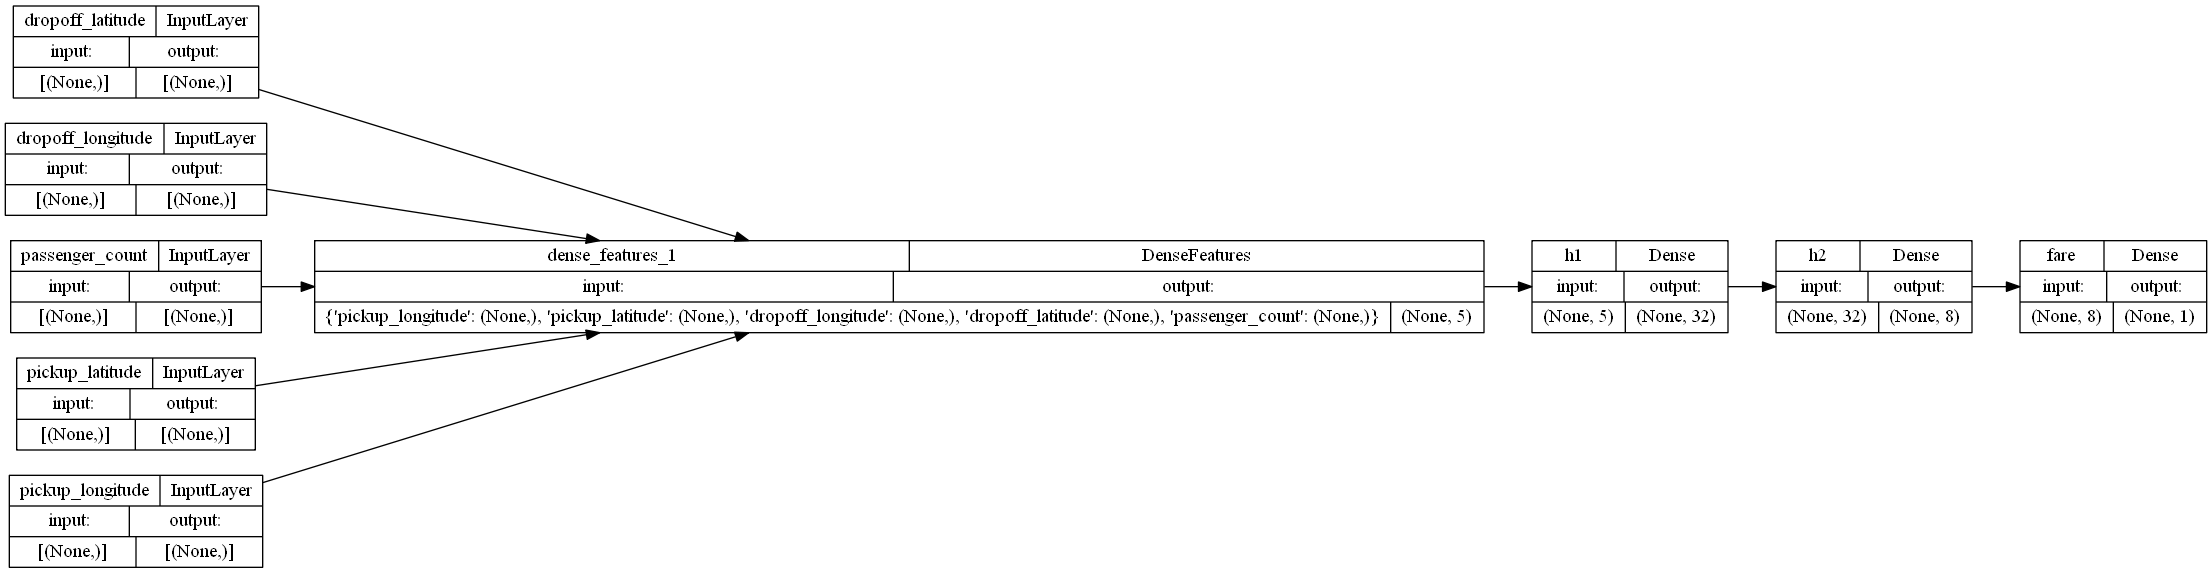

In [14]:
import pydot
import graphviz
tf.keras.utils.plot_model(model, 'dnn_model.png', show_shapes=True, rankdir='LR')

In [11]:
TRAIN_BATCH_SIZE = 32
NUM_TRAIN_EXAMPLES = 10000 * 5 #
NUM_EVALS = 32 
NUM_EVAL_EXAMPLES = 10000 

trainds = load_dataset('traffic-taxi-train*', TRAIN_BATCH_SIZE, tf.estimator.ModeKeys.TRAIN)
evalds = load_dataset('traffic-taxi-valid*', 1000, tf.estimator.ModeKeys.EVAL).take(NUM_EVAL_EXAMPLES//1000)

steps_per_epoch = NUM_TRAIN_EXAMPLES // (TRAIN_BATCH_SIZE * NUM_EVALS)

# Model Fit
history = model.fit(trainds, 
                    validation_data=evalds,
                    epochs=NUM_EVALS, 
                    steps_per_epoch=steps_per_epoch)

Epoch 1/32
48/48 [==============================] - 19s 83ms/step - loss: 187.0120 - rmse: 68429.5312 - mse: 187.0120 - val_loss: 110.5706 - val_rmse: 12329.9902 - val_mse: 110.5706
Epoch 2/32
48/48 [==============================] - 1s 16ms/step - loss: 95.9510 - rmse: 13695.0029 - mse: 95.9510 - val_loss: 110.0062 - val_rmse: 12278.0596 - val_mse: 110.0062
Epoch 3/32
48/48 [==============================] - 1s 12ms/step - loss: 93.9678 - rmse: 11749.6484 - mse: 93.9678 - val_loss: 111.5600 - val_rmse: 12613.5195 - val_mse: 111.5600
Epoch 4/32
48/48 [==============================] - 1s 12ms/step - loss: 89.2860 - rmse: 13132.4639 - mse: 89.2860 - val_loss: 110.6019 - val_rmse: 12418.7090 - val_mse: 110.6019
Epoch 5/32
48/48 [==============================] - 1s 12ms/step - loss: 86.7239 - rmse: 10589.3467 - mse: 86.7239 - val_loss: 110.0505 - val_rmse: 12165.0879 - val_mse: 110.0505
Epoch 6/32
48/48 [==============================] - 1s 12ms/step - loss: 103.9464 - rmse: 29636.6074 -

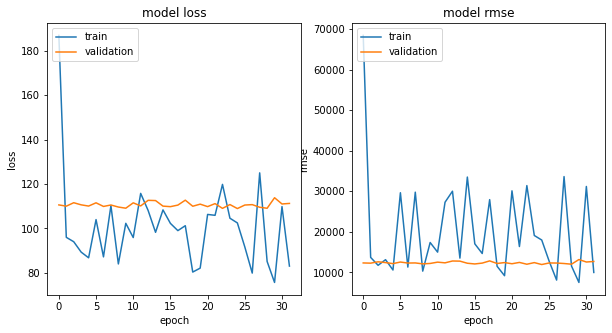

In [12]:
import matplotlib.pyplot as plt
nrows = 1
ncols = 2

fig = plt.figure(figsize=(10, 5))

for idx, key in enumerate(['loss', 'rmse']):
    ax = fig.add_subplot(nrows, ncols, idx+1)
# The .plot() is a versatile function, and will take an arbitrary number of arguments. For example, to plot x versus y.
    plt.plot(history.history[key])
    plt.plot(history.history['val_{}'.format(key)])
# The .title() method sets a title for the axes.
    plt.title('model {}'.format(key))
    plt.ylabel(key)
    plt.xlabel('epoch')
# The .legend() method will place a legend on the axes.
    plt.legend(['train', 'validation'], loc='upper left');

In [15]:
model.predict({
    'pickup_longitude': tf.convert_to_tensor([-73.982683]),
    'pickup_latitude': tf.convert_to_tensor([40.742104]),
    'dropoff_longitude': tf.convert_to_tensor([-73.983766]),
    'dropoff_latitude': tf.convert_to_tensor([40.755174]),
    'passenger_count': tf.convert_to_tensor([3.0]),    
}, steps=1)

1/1 [==============================] - 1s 909ms/step


array([[10.387272]], dtype=float32)